# **&nbsp;TRABAJO FINAL DEL BOOTCAMP IV BIG DATA & MACHINE LEARNING**

                                           Alumno  Francisco Javier Gonzálvez Chico
                                           Título  Recomendador de Precios para Anfitriones de AirBNB España


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**CUADERNO DE TRABAJO 03**
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Reducción de la Dimensionalidad y Proceso de la Muestra de Test**

En los notebooks se codificarán las celdas con las que se procesarán las acciones sobre el dataset de trabajo y las ejecuciones de los modelos.
No se comentarán ya que toda la documentación del trabajo se presentará en un documento Word en el que irá incluido este notebook.

 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_trn = pd.read_csv('./train_cleaned.csv', sep = ';', decimal = '.')

In [3]:
from sklearn.preprocessing import StandardScaler

values_trn = data_trn.values

feature_names = data_trn.columns[0:-4]

X_trn = values_trn[:, 0:-4]
y_trn = values_trn[:, -4:-3]

scaler = StandardScaler().fit(X_trn)
X_trn_Sc = scaler.transform(X_trn)

In [4]:
def plot_importance_coefs(importances, data, feature_names, algorithm):
    importances /= np.max(importances)
    indices = np.argsort(importances)[::-1]
    
    my_colors = [(x/(len(importances)), x/(2*len(importances)),
                  .4) for x in range(len(importances))]
    
    plt.figure(figsize = (8, 5))
    
    plt.bar(range(data.shape[1]), importances[indices],
            label = algorithm, color = my_colors)
    plt.xticks(range(data.shape[1]), feature_names[indices],
               rotation = 90, fontsize = 14)
    plt.legend(loc = 1, fontsize = 16)
    
    plt.show()

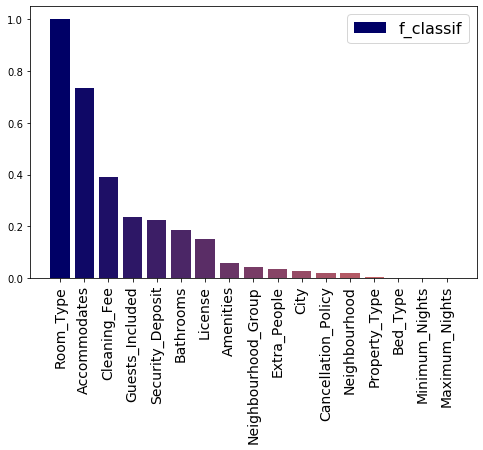

In [5]:
from sklearn.feature_selection import f_classif

f_cls , _ = f_classif(X_trn_Sc, y_trn)
f_cls /= np.max(f_cls)

plot_importance_coefs(f_cls, X_trn_Sc, feature_names,
                      'f_classif')

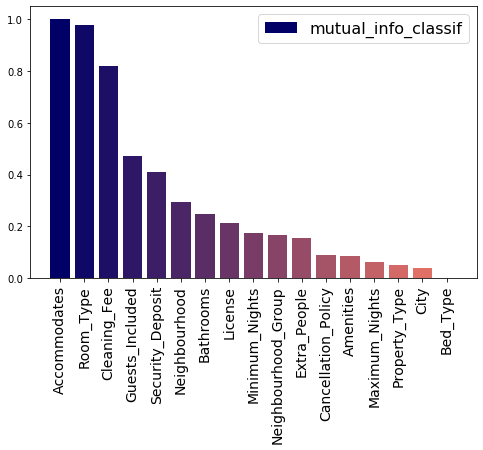

In [6]:
from sklearn.feature_selection import mutual_info_classif

mi_cls = mutual_info_classif(X_trn_Sc, y_trn)
mi_cls /= np.max(mi_cls)

plot_importance_coefs(mi_cls, X_trn_Sc, feature_names,
                      'mutual_info_classif')

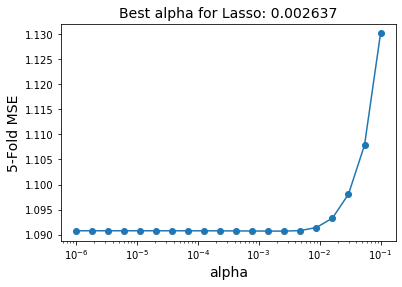

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_Lasso = np.logspace(-6, -1, 20)
parameters_Lasso = {'alpha': alpha_Lasso}

gs_Lasso = GridSearchCV(Lasso(random_state = 0),
                        scoring = 'neg_mean_squared_error',
                        param_grid = parameters_Lasso,
                        cv = 5)
gs_Lasso.fit(X_trn_Sc, y_trn)

scores = -1*np.array(gs_Lasso.cv_results_['mean_test_score'])

plt.title("Best alpha for Lasso: " + 
          f"{gs_Lasso.best_params_['alpha']:,.6f}",
          fontsize = 14)
plt.semilogx(alpha_Lasso, scores, '-o')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('5-Fold MSE', fontsize = 14)
plt.show()

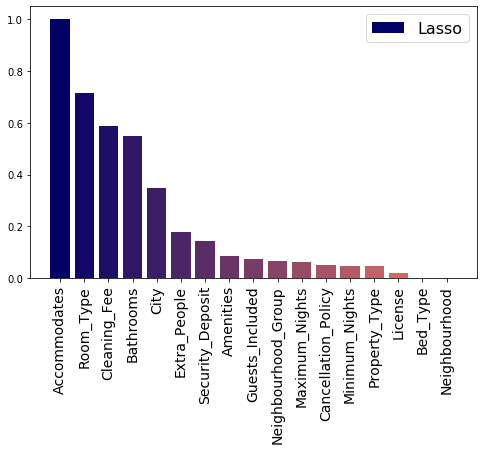

In [8]:
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha = gs_Lasso.best_params_['alpha'], random_state = 0)
lasso.fit(X_trn_Sc, y_trn)

w = np.absolute(lasso.coef_ / np.max(lasso.coef_))

plot_importance_coefs(w, X_trn_Sc, feature_names, 'Lasso')

In [9]:
from sklearn.tree import DecisionTreeClassifier

max_depth_DTC = range(4, 12)
parameters_DTC = {'max_depth': max_depth_DTC}

gs_DTC = GridSearchCV(DecisionTreeClassifier(random_state = 0),
                      param_grid = parameters_DTC, cv = 5)


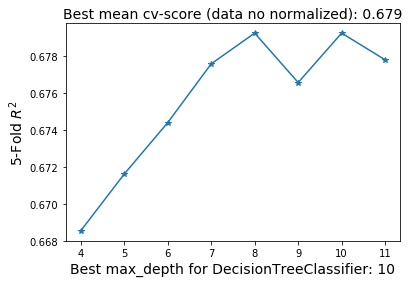

In [10]:
# Entreno una copia de la Grid DecisionTreeClassifier
# con datos sin normalizar

gs_DTC_nn = gs_DTC

gs_DTC_nn.fit(X_trn, y_trn)

plt.title("Best mean cv-score (data no normalized): " + 
          f"{gs_DTC_nn.best_score_:.3f}", fontsize = 14)
plt.plot(max_depth_DTC, 
         np.array(gs_DTC_nn.cv_results_['mean_test_score']),
         '-*')
plt.xlabel("Best max_depth for DecisionTreeClassifier: " + 
          f"{gs_DTC_nn.best_params_['max_depth']}",
          fontsize = 14)
plt.ylabel('5-Fold $R^2$', fontsize = 14)
plt.show()

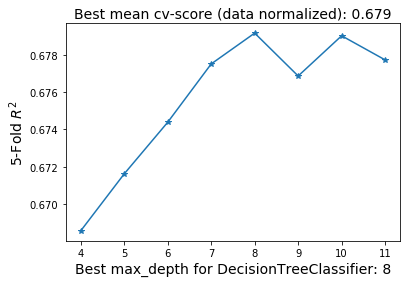

In [11]:
# Entreno una copia de la Grid DecisionTreeClassifier
# con datos normalizados

gs_DTC_sn = gs_DTC

gs_DTC_sn.fit(X_trn_Sc, y_trn)

plt.title("Best mean cv-score (data normalized): " + 
          f"{gs_DTC_sn.best_score_:.3f}", fontsize = 14)
plt.plot(max_depth_DTC, 
         np.array(gs_DTC_sn.cv_results_['mean_test_score']),
         '-*')
plt.xlabel("Best max_depth for DecisionTreeClassifier: " + 
          f"{gs_DTC_sn.best_params_['max_depth']}",
          fontsize = 14)
plt.ylabel('5-Fold $R^2$', fontsize = 14)
plt.show()

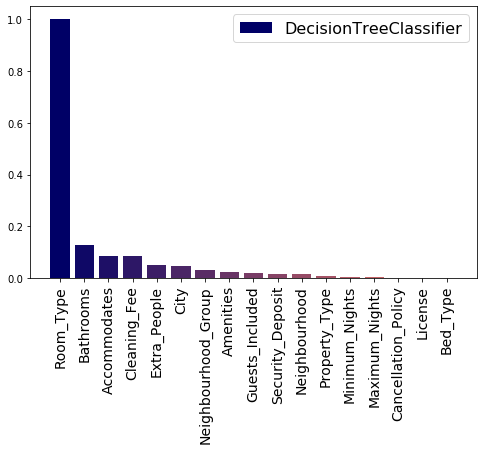

In [12]:
treeC = DecisionTreeClassifier(max_depth = gs_DTC_sn.best_params_['max_depth'],
                               random_state = 0)
treeC.fit(X_trn_Sc, y_trn)

plot_importance_coefs(treeC.feature_importances_, X_trn_Sc, feature_names,
                      'DecisionTreeClassifier')

In [13]:
from sklearn.ensemble import RandomForestClassifier

max_depth_RFC = range(15, 25)
n_estimators_RFC = range(400, 550, 50)
parameters_RFC = {'max_depth': max_depth_RFC,
                  'n_estimators': n_estimators_RFC}

gs_RFC = GridSearchCV(RandomForestClassifier(random_state = 0,
                                             max_features = 'sqrt'),
                      param_grid = parameters_RFC, cv = 5)

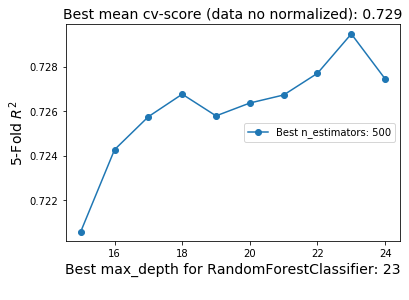

In [14]:
# Entreno una copia de la Grid RandomForestClassifier
# con datos sin normalizar

gs_RFC_nn = gs_RFC

gs_RFC_nn.fit(X_trn, y_trn)

scores = gs_RFC_nn.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(max_depth_RFC),
                                  len(n_estimators_RFC))
scores = scores.T

for idx, val in enumerate(n_estimators_RFC):
    if val == gs_RFC_nn.best_params_['n_estimators']:
        plt.plot(max_depth_RFC, scores[idx, :], '-o',
                 label = 'Best n_estimators' + ': ' + str(val))
        plt.title("Best mean cv-score (data no normalized): " +
                  f"{gs_RFC_nn.best_score_:.3f}",fontsize = 14)
        plt.xlabel("Best max_depth for RandomForestClassifier: " +
                   f"{gs_RFC_nn.best_params_['max_depth']}\n",
                   fontsize = 14)
        plt.ylabel('5-Fold $R^2$', fontsize = 14)
        plt.legend(loc = 5, fontsize = 10)

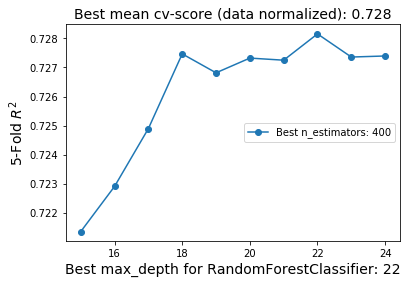

In [15]:
# Entreno una copia de la Grid RandomForestClassifier
# con datos normalizados

gs_RFC_sn = gs_RFC

gs_RFC_sn.fit(X_trn_Sc, y_trn)

scores = gs_RFC_sn.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(max_depth_RFC),
                                  len(n_estimators_RFC))
scores = scores.T

for idx, val in enumerate(n_estimators_RFC):
    if val == gs_RFC_sn.best_params_['n_estimators']:
        plt.plot(max_depth_RFC, scores[idx, :], '-o',
                 label = 'Best n_estimators' + ': ' + str(val))
        plt.title("Best mean cv-score (data normalized): " +
                  f"{gs_RFC_sn.best_score_:.3f}",fontsize = 14)
        plt.xlabel("Best max_depth for RandomForestClassifier: " +
                   f"{gs_RFC_sn.best_params_['max_depth']}\n",
                   fontsize = 14)
        plt.ylabel('5-Fold $R^2$', fontsize = 14)
        plt.legend(loc = 5, fontsize = 10)

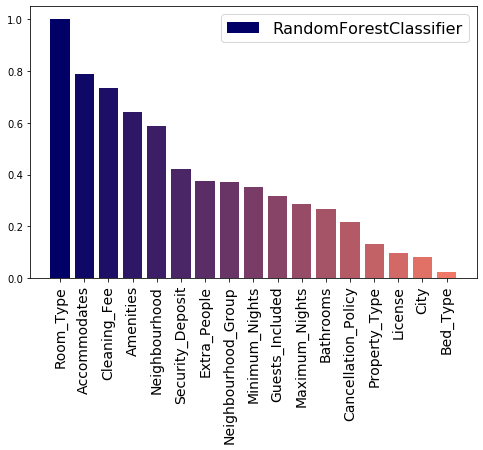

In [16]:
rfC = RandomForestClassifier(max_depth = gs_RFC_sn.best_params_['max_depth'],
                             n_estimators = gs_RFC_sn.best_params_['n_estimators'],
                             max_features = 'sqrt', random_state = 0)
rfC.fit(X_trn_Sc, y_trn)

plot_importance_coefs(rfC.feature_importances_, X_trn_Sc, feature_names,
                      'RandomForestClassifier')

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

max_depth_GBC = [3, 4, 5]
n_estimators_GBC = [1500, 2000]
learning_rate_GBC = [0.1, 0.05]

for i in max_depth_GBC:
    for j in n_estimators_GBC:
        for k in learning_rate_GBC:
            gbC = GradientBoostingClassifier(random_state = 0, max_depth = i,
                                             n_estimators = j, learning_rate = k)
            gbC.fit(X_trn_Sc, y_trn)
            
            if(i == max_depth_GBC[0] and
               j == n_estimators_GBC[0] and
               k == learning_rate_GBC[0]):
                print("Score R\u00b2 (data normalized) with:")

            print(f"\tmax_depth {i};  n_estimators {j};  " +
                  f"learning_rate {k}\t-->\t{gbC.score(X_trn_Sc, y_trn):.3f}")

Score R² (data normalized) with:
	max_depth 3;  n_estimators 1500;  learning_rate 0.1	-->	0.809
	max_depth 3;  n_estimators 1500;  learning_rate 0.05	-->	0.798
	max_depth 3;  n_estimators 2000;  learning_rate 0.1	-->	0.810
	max_depth 3;  n_estimators 2000;  learning_rate 0.05	-->	0.811
	max_depth 4;  n_estimators 1500;  learning_rate 0.1	-->	0.843
	max_depth 4;  n_estimators 1500;  learning_rate 0.05	-->	0.859
	max_depth 4;  n_estimators 2000;  learning_rate 0.1	-->	0.844
	max_depth 4;  n_estimators 2000;  learning_rate 0.05	-->	0.877
	max_depth 5;  n_estimators 1500;  learning_rate 0.1	-->	0.964
	max_depth 5;  n_estimators 1500;  learning_rate 0.05	-->	0.921
	max_depth 5;  n_estimators 2000;  learning_rate 0.1	-->	0.978
	max_depth 5;  n_estimators 2000;  learning_rate 0.05	-->	0.940


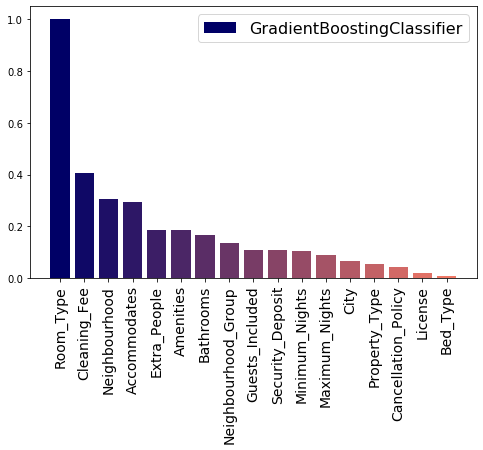

In [18]:
gbC = GradientBoostingClassifier(random_state = 0,
                                 max_depth = 5,
                                 n_estimators = 2000,
                                 learning_rate = 0.1)
gbC.fit(X_trn_Sc, y_trn)

plot_importance_coefs(gbC.feature_importances_, X_trn_Sc,
                      feature_names, 'GradientBoostingClassifier')

In [6]:
data_trn.drop(['Bed_Type'], axis = 1, inplace = True)

In [7]:
data_trn.T

,0,1,2,3,4,5,6,7,8,9,...,27649,27650,27651,27652,27653,27654,27655,27656,27657,27658
City,1,0,1,0,0,1,1,1,0,1,...,0,0,1,0,0,1,1,1,1,1
License,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
Neighbourhood_Group,30,31,27,31,20,12,28,30,23,30,...,20,31,30,31,31,29,30,30,21,26
Neighbourhood,183,71,169,55,46,83,168,183,49,176,...,46,135,176,55,44,156,176,124,188,194
Property_Type,13,13,13,13,13,13,13,13,11,13,...,12,0,13,13,10,13,13,11,13,13
Room_Type,1,2,2,2,2,1,2,1,1,1,...,1,2,2,2,2,1,2,1,2,2
Accommodates,2,3,6,4,4,3,4,2,1,2,...,1,4,8,2,2,2,8,2,3,2
Guests_Included,4,2,4,2,1,1,2,1,1,1,...,1,2,5,1,1,1,6,1,1,1
Minimum_Nights,1,1,2,2,4,1,2,1,2,1,...,2,1,3,2,1,1,3,1,1,1
Maximum_Nights,31,1125,1125,160,1125,1125,1125,1125,4,1125,...,1125,60,1125,1125,1125,1125,1125,1125,1125,1125


In [8]:
data_tst = pd.read_csv('./test.csv', sep = ';', decimal = '.')

data_tst.drop(['Experiences Offered', 'Beds', 'Bedrooms',
               'Bed Type', 'Square Feet'], axis = 1, inplace = True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_tst = data_tst.drop(data_tst[(data_tst['Neighbourhood Cleansed'].isnull())].index)
data_tst['Neighbourhood'] = le.fit_transform(data_tst['Neighbourhood Cleansed'])
data_tst.drop(['Neighbourhood Cleansed'], axis = 1, inplace = True)

ngg_d = {'Otros Distritos': 0, 'Vicálvaro': 1, 'Villa de Vallecas': 2, 'Moratalaz': 3,
         'Barajas': 4, 'Villaverde': 5, 'San Blas - Canillejas': 6, 'Usera': 7,
         'Fuencarral - El Pardo': 8, 'Hortaleza': 9, 'Nou Barris': 10,
         'Puente de Vallecas': 11, 'Sant Andreu': 12, 'Ciudad Lineal': 13,          
         'Les Corts': 14, 'Chamartín': 15, 'Carabanchel': 16, 'Latina': 17,
         'Moncloa - Aravaca': 18, 'Retiro': 19, 'Retiro': 19, 'Tetuán': 20,
         'Horta-Guinardó': 21, 'Sarrià-Sant Gervasi': 22, 'Arganzuela': 23,
         'Salamanca': 24, 'Chamberí': 25, 'Gràcia': 26, 'Sant Martí': 27,
         'Sants-Montjuïc': 28, 'Ciutat Vella': 29, 'Eixample': 30, 'Centro': 31}
data_tst['Neighbourhood_Group'] = data_tst['Neighbourhood Group Cleansed'].map(ngg_d)
data_tst['Neighbourhood_Group'] = np.where((data_tst['Neighbourhood_Group'].isnull()), 0,
                                           data_tst['Neighbourhood_Group'])
data_tst.drop(['Neighbourhood Group Cleansed'], axis = 1, inplace = True)

data_tst['City'] = np.where((data_tst['City'].str.contains('arcel'))
                            | ((data_tst['City'].str.contains('ARCEL'))),
                            1, data_tst['City'])
data_tst['City'] = np.where((data_tst['City'].str.contains('adr'))
                            | ((data_tst['City'].str.contains('ADR'))),
                            0, data_tst['City'])

pt_d = {'Boutique hotel': 1, 'Villa': 2, 'Serviced apartment': 3, 'Chalet': 4,
        'Hostel': 5, 'Boat': 6, 'Guesthouse': 7, 'Dorm': 8, 'Loft': 9,
        'Condominium': 10, 'Bed & Breakfast': 11, 'House': 12, 'Apartment': 13}
data_tst['Property_Type'] = data_tst['Property Type'].map(pt_d)
data_tst['Property_Type'] = np.where((data_tst['Property_Type'].isnull()), 0,
                                     data_tst['Property_Type'])
data_tst.drop(['Property Type'], axis = 1, inplace = True)

rt_d = {'Shared room': 0, 'Private room': 1, 'Entire home/apt': 2}
data_tst['Room_Type'] = data_tst['Room Type'].map(rt_d)
data_tst['Room_Type'] = np.where((data_tst['Room_Type'].isnull()),
                                 2, data_tst['Room_Type'])
data_tst.drop(['Room Type'], axis = 1, inplace = True)

data_tst['Accommodates'] = np.where((data_tst['Accommodates'].isnull()),
                                    2, data_tst['Accommodates'])

data_tst['Bathrooms'] = np.where((data_tst['Bathrooms'].isnull())
                                 & ((data_tst['Room_Type'] == 0)
                                    | (data_tst['Room_Type'] == 1)),
                                 0.0, data_tst['Bathrooms'])
data_tst['Bathrooms'] = np.where((data_tst['Bathrooms'].isnull())
                                 & (data_tst['Room_Type'] == 2),
                                 1.0, data_tst['Bathrooms'])

data_tst['Amenities'] = np.where((data_tst['Amenities'].isnull()), '0',
                                 data_tst['Amenities'])
data_tst['Amenities'] = np.where((data_tst['Amenities'] == '0'), 0,
                                 data_tst['Amenities'].apply(lambda x: len(x.split(","))))

data_tst['Price'] = np.where((data_tst['Price'].isnull()
                              & (~data_tst['Weekly Price'].isnull())),
                             np.around(data_tst['Weekly Price'] / 7,
                                       0), data_tst['Price'])
data_tst['Price'] = np.where((data_tst['Price'].isnull()
                              & (~data_tst['Monthly Price'].isnull())),
                             np.around(data_tst['Monthly Price'] / 30,
                                       0), data_tst['Price'])
data_tst = data_tst.drop(data_tst[(data_tst['Price'].isnull())].index)

data_tst.drop(['Weekly Price', 'Monthly Price'], axis = 1, inplace = True)

data_tst['Security_Deposit'] = np.where((data_tst['Security Deposit'].isnull()),
                                        0.0, data_tst['Security Deposit'])
data_tst.drop(['Security Deposit'], axis = 1, inplace = True)

data_tst['Cleaning_Fee'] = np.where((data_tst['Cleaning Fee'].isnull()),
                                    0.0, data_tst['Cleaning Fee'])
data_tst.drop(['Cleaning Fee'], axis = 1, inplace = True)

data_tst['Guests_Included'] = np.where((data_tst['Guests Included'].isnull()),
                                       1, data_tst['Guests Included'])
data_tst.drop(['Guests Included'], axis = 1, inplace = True)

data_tst['Extra_People'] = np.where((data_tst['Extra People'].isnull()),
                                    0, data_tst['Extra People'])
data_tst.drop(['Extra People'], axis = 1, inplace = True)

data_tst['Minimum_Nights'] = np.where((data_tst['Minimum Nights'].isnull()),
                                      2, data_tst['Minimum Nights'])
data_tst.drop(['Minimum Nights'], axis = 1, inplace = True)

data_tst['Maximum_Nights'] = np.where((data_tst['Maximum Nights'].isnull()),
                                      1125, data_tst['Maximum Nights'])
data_tst.drop(['Maximum Nights'], axis = 1, inplace = True)

data_tst['License'] = np.where((data_tst['License'].isnull()),
                               0, data_tst['License'])
data_tst['License'] = np.where((data_tst['License'] != 0),
                               1, data_tst['License'])

cp_d = {'super_strict_60': 0, 'super_strict_30': 1, 'moderate': 2, 'flexible': 3, 'strict': 4}
data_tst['Cancellation_Policy'] = data_tst['Cancellation Policy'].map(cp_d)
data_tst['Cancellation_Policy'] = np.where((data_tst['Cancellation_Policy'].isnull()),
                                           0, data_tst['Cancellation_Policy'])
data_tst.drop(['Cancellation Policy'], axis = 1, inplace = True)

data_tst['Reviews_per_Month'] = np.where((data_tst['Reviews per Month'].isnull()), 
                                         0.0, data_tst['Reviews per Month'])
data_tst.drop(['Reviews per Month'], axis = 1, inplace = True)

data_tst['Range Prices'] = np.where((data_tst['Price'] <= 50), 25, data_tst['Price'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 50) & (data_tst['Range Prices'] <= 100),
                                    75, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 100) & (data_tst['Range Prices'] <= 150),
                                    125, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 150) & (data_tst['Range Prices'] <= 200),
                                    175, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 200) & (data_tst['Range Prices'] <= 250),
                                    225, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 250) & (data_tst['Range Prices'] <= 300),
                                    275, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 300) & (data_tst['Range Prices'] <= 350),
                                    325, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 350) & (data_tst['Range Prices'] <= 400),
                                    375, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 400) & (data_tst['Range Prices'] <= 450),
                                    425, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 450) & (data_tst['Range Prices'] <= 500),
                                    475, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 500) & (data_tst['Range Prices'] <= 550),
                                    525, data_tst['Range Prices'])
data_tst['Range Prices'] = np.where((data_tst['Range Prices'] > 550), 575, data_tst['Range Prices'])
rp_d = {25.0: 1, 75.0: 2, 125.0: 3, 175.0: 4, 225.0: 5, 275.0: 6,
        325.0: 7, 375.0: 8, 425.0: 9, 475.0: 10, 525.0: 11, 575.0: 12}
data_tst['Range_Prices'] = data_tst['Range Prices'].map(rp_d)
data_tst.drop(['Range Prices'], axis = 1, inplace = True)

r_d = {1: 'hasta 50€', 2: 'entre 50~100€', 3: 'entre 100~150€',
       4: 'entre 150~200€', 5: 'entre 200~250€', 6: 'entre 250~300€',
       7: 'entre 300~350€', 8: 'entre 350~400€', 9: 'entre 400~450€',
       10: 'entre 450~500€', 11: 'entre 500~550€', 12: 'más de 550€'}
data_tst['Ranges'] = data_tst['Range_Prices'].map(r_d)

data_tst = data_tst[['City', 'License', 'Neighbourhood_Group', 'Neighbourhood',
                     'Property_Type', 'Room_Type', 'Accommodates', 'Guests_Included',
                     'Minimum_Nights', 'Maximum_Nights', 'Cancellation_Policy',
                     'Bathrooms', 'Amenities', 'Extra_People', 'Security_Deposit',
                     'Cleaning_Fee', 'Range_Prices', 'Ranges', 'Price',
                     'Reviews_per_Month']]

In [10]:
print('El subset de Entrenamiento tiene' + 
      f' {data_trn.shape[0]} filas y {data_trn.shape[1] - 4} + 1 columnas')
print('El subset de Testeo tiene' + 
      f' {data_tst.shape[0]} filas y {data_tst.shape[1] - 4} + 1 columnas')

print("\nSubset de Entrenamiento\n" + "-"*28 + "\n",
      data_trn.isnull().any(),
      "\n\nSubset de Test\n" + "-"*28 + "\n",
      data_tst.isnull().any(), sep = '')

El subset de Entrenamiento tiene 27659 filas y 16 + 1 columnas
El subset de Testeo tiene 3075 filas y 16 + 1 columnas

Subset de Entrenamiento
----------------------------
City                   False
License                False
Neighbourhood_Group    False
Neighbourhood          False
Property_Type          False
Room_Type              False
Accommodates           False
Guests_Included        False
Minimum_Nights         False
Maximum_Nights         False
Cancellation_Policy    False
Bathrooms              False
Amenities              False
Extra_People           False
Security_Deposit       False
Cleaning_Fee           False
Range_Prices           False
Ranges                 False
Price                  False
Reviews_per_Month      False
dtype: bool

Subset de Test
----------------------------
City                   False
License                False
Neighbourhood_Group    False
Neighbourhood          False
Property_Type          False
Room_Type              False
Accommodates     

In [12]:
data_trn.to_csv('./train_def.csv', sep = ';', decimal = '.', index = False)
data_tst.to_csv('./test_def.csv', sep = ';', decimal = '.', index = False)